# Dual identification of novel phage receptor-binding proteins based on protein domains and machine learning

This notebook serves as the main document of code and analyses for the detection of phage RBPs in genomes and metagenomes.

## 0. Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from random import sample
from Bio import SeqIO, Entrez
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import OneClassSVM
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, IsolationForest
from sklearn.model_selection import GridSearchCV, StratifiedKFold, GroupKFold, cross_val_predict, train_test_split
from sklearn.metrics import precision_score, roc_auc_score, make_scorer, roc_curve, confusion_matrix, f1_score
%matplotlib inline

In [2]:
# set directories
data_dir = '/Users/Dimi/GoogleDrive/PhD/3_PHAGEBASE/32_DATA/RBP_detection/'
results_dir = '/Users/Dimi/GoogleDrive/PhD/3_PHAGEBASE/33_RESULTS/RBP_detection/'

## 1. Loading and processing data

- Get MillardLab data: tsv file (filtered genomes with information on name, host, family etc) and unfiltered GenBank file of phage genomes (to extract relevant records from) from their website.
- Get Genbank records for the relevant phages (either a species, or all filtered from MillardLab) -> genbank collection
- Appy filters to construct RBP vs. non-RBP database + keep phage genome IDs!
- transform into embeddings: cfr protein_embeddings_cloud (compute with GPU in Kaggle notebooks)

In [99]:
def genbank_collection(MillardLab_tsv, MillardLab_genbank, directory, species_filter=''):
    """
    This function loops over the filtered and unfiltered phage genome data of MillardLab to construct one or multiple
    genbank files of those genomes for further analysis.
    
    Input:
    - MillardLab_tsv: handle (string) to the filtered tsv file of MillardLab phage genomes
    - MillardLab_genbank: handle (string) to the unfiltered phage genomes downloaded from NCBI by MillardLab
    - species_filter (optional): string of which species to filter for (will be searched for in 'Description')
    - family_separated (optional): bool of whether or not to separate different phage families into separate files
    
    Output: One or multiple genbank files of relevant records.
    """
    tsv_data = pd.read_csv(MillardLab_tsv, sep='\t')
    records = SeqIO.parse(MillardLab_genbank, 'gb')
    stop_iter = 0
    genbank_file = open(directory+'MillardLab_genbank_filtered.txt', 'w')
    
    while stop_iter >= 0:
        try:
            record = next(records)
            if record.name in tsv_data['Accession']:
                SeqIO.write(record, genbank_file, 'genbank')
            if stop_iter%1000 == 0:
                print('iteration:', stop_iter)
        except StopIteration:
            stop_iter = -1
        except:
            pass
    genbank_file.close()
        
    if species_filter != '':
        species_genbank_file = open(directory+'MillardLab_genbank_filtered_'+species_filter+'.txt', 'w')
        for record in SeqIO.parse(directory+'MillardLab_genbank_filtered.txt', 'gb'):
            if species_filter in record.description:
                SeqIO.write(record, species_genbank_file, 'genbank')
    species_genbank_file.close()
                
    return

In [5]:
# load processed data
rbps = pd.read_csv(data_dir+'annotated_RBPs.csv', sep='\t')
nonrbps = pd.read_csv(data_dir+'annotated_nonRBPs.csv', sep='\t')

In [42]:
nonrbps.head()

,NCBI_id,UniProt_id,Tax_id,EMBL_id,Accession,Realm,Family,Organism,Host,ProteinName,ProteinSeq,DNASeq,From,ProteinType
0,QNI20952.1,-,-,-,MT811961,Duplodnaviria,Myoviridae,Vibrio phage vB_pir03,Vibrio harveyi,virion structural protein,MYILNRSYVFDSFFGSWDRKDLSLYKISEIMKFPDFKLILSLQTEP...,ATGTATATTTTGAATCGCTCCTATGTCTTCGATAGCTTTTTCGGCT...,Alex,NonRBP
1,QNI20955.1,-,-,-,MT811961,Duplodnaviria,Myoviridae,Vibrio phage vB_pir03,Vibrio harveyi,PAAR repeat-containing protein,MGKPASSGTQPCTGHGCFPPSTVTGTSPDVTINGQPAMLAGDPMAP...,ATGGGTAAACCAGCTTCATCGGGTACACAGCCCTGTACAGGACATG...,Alex,NonRBP
2,QNI20958.1,-,-,-,MT811961,Duplodnaviria,Myoviridae,Vibrio phage vB_pir03,Vibrio harveyi,virion structural protein,MENRDVVYIIDAFAEIQSLISNDNKVTTPAGELSPRAKAYTRDLRT...,ATGGAGAATAGAGACGTGGTTTATATTATTGATGCGTTCGCTGAAA...,Alex,NonRBP
3,QNI20961.1,-,-,-,MT811961,Duplodnaviria,Myoviridae,Vibrio phage vB_pir03,Vibrio harveyi,ribonuclease H,MKSVTIHTDGGATADAEVGYYGGWGVHISVDEEDTELLICAACPHG...,ATGAAATCTGTTACTATCCACACCGATGGTGGTGCAACAGCTGATG...,Alex,NonRBP
4,QNI20963.1,-,-,-,MT811961,Duplodnaviria,Myoviridae,Vibrio phage vB_pir03,Vibrio harveyi,UvsX protein,MSAVFLLFSSQSSVPVMASSTLSTKESKLSNFSVSNWNSCLIACSV...,ATGTCAGCAGTTTTCTTGTTGTTCAGTAGCCAATCGAGCGTCCCCG...,Alex,NonRBP


In [25]:
rbps.head()

,NCBI_id,UniProt_id,Tax_id,EMBL_id,Accession,Realm,Family,Organism,Host,ProteinName,ProteinSeq,DNASeq,From,ProteinType
0,QIW86450.1,-,-,-,MT241605,Duplodnaviria,Siphoviridae,Achromobacter phage AMA1,Achromobacter marplatensis,putative tail fiber protein,MATLLLIENAFRPDANPRQEPVRAGERISSMLRRIGYLKGRGAKAV...,ATGGCAACCCTGCTGCTGATTGAAAACGCTTTCCGCCCAGACGCGA...,Alex,RBP
1,QIG62429.1,-,-,-,MT002875,Duplodnaviria,Siphoviridae,Pseudoalteromonas phage AL,Pseudoalteromonas marina,putative tail fiber adhesion protein,MAFDTVKKTFTKEHMWIVELISGETTYRFCENRSPLPLELEAVPSL...,ATGGCTTTTGATACAGTTAAAAAAACATTCACTAAAGAACATATGT...,Alex,RBP
2,QNR53876.1,-,-,-,MT740307,Duplodnaviria,Myoviridae,Pseudomonas phage phiK7A1,Pseudomonas syringae pv. actinidiae K7A1,putative tail fiber protein,MVDITKLDMTNIWASGGDKVTPSAEKIAQGWVVEAVPRQTWNWFEN...,ATGGTGGACATTACTAAACTGGATATGACAAATATCTGGGCAAGCG...,Alex,RBP
3,QNR53879.1,-,-,-,MT740307,Duplodnaviria,Myoviridae,Pseudomonas phage phiK7A1,Pseudomonas syringae pv. actinidiae K7A1,putative tail fiber protein,MANLLKPTGVNNIWSINGTKTDPGLAKANTGWVVELPPYQTANWIE...,ATGGCTAACTTGCTAAAGCCTACAGGTGTGAACAACATCTGGAGTA...,Alex,RBP
4,QNR52067.1,-,-,-,MT833282,Duplodnaviria,Myoviridae,Escherichia coli phage vB_EcoM_Shy,Escherichia coli NCTC 12900,putative tail fiber protein,MAVGEIQISALPQAALPIDLSDIFHLKQGVEDKRCTLEQLLAPHAS...,ATGGCAGTAGGTGAAATTCAAATTAGTGCCTTGCCACAAGCGGCCT...,Alex,RBP


## 2. Learning patterns and evaluating models

Findings:
- we see that standard scaling does not affect peformance.
- the One-class approaches don't seem to work, at least not at a split of 1:10. Perhaps the high dimensionality is also a problem...
- The XGBoost classifier seems to work best so far.
- The AUC metric considers both the majority and minority class, which can give an overly optimistic estimate of performance. The F1 score considers only the positive/minority class.

In [3]:
# load processed data
rbp_embeddings_df = pd.read_csv(data_dir+'annotated_RBPs_embeddings.csv')
nonrbp_embeddings_df = pd.read_csv(data_dir+'annotated_nonRBPs_embeddings.csv')
rbp_embed = np.asarray(rbp_embeddings_df.iloc[:, 2:])
nonrbp_embed = np.asarray(nonrbp_embeddings_df.iloc[:, 2:])

features = np.concatenate((rbp_embed, nonrbp_embed))
labels = np.asarray([1]*rbp_embed.shape[0] + [0]*nonrbp_embed.shape[0])
print('Check?', features.shape[0]==labels.shape[0])

Check? True


#### PCA & TSNE

In [20]:
# PCA to visualize class separation
pca = PCA(n_components=5)
fr_pca = pca.fit_transform(features)
print(pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_))

tsne = TSNE(n_components=100)
fr_tsne = tsne.fit_transform(features)

[0.2342101  0.16402612 0.13155598 0.07266402 0.03720639] 0.6396626158738277


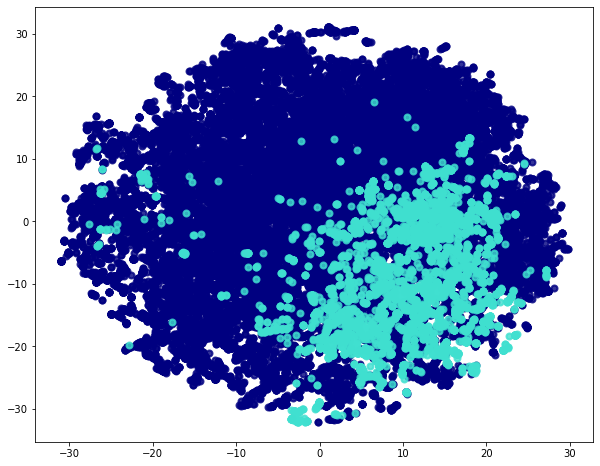

In [21]:
fr = fr_tsne
fig, ax = plt.subplots(figsize=(10, 8))
colors = ["navy", "turquoise"]
for color, i in zip(colors, [0, 1]):
    ax.scatter(fr[labels == i, 0], fr[labels == i, 1], color=color, alpha=0.8, lw=2)

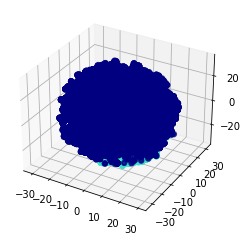

In [22]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for color, i in zip(colors, [0, 1]):
    ax.scatter(fr[labels == i, 0], fr[labels == i, 1], fr[labels == i, 2], color=color, alpha=0.8, lw=2)

#### Cross-validated evaluation

In [6]:
# train one-class models on high imbalance with reduced features
nonrbp_embeddings_df_big = pd.read_csv(data_dir+'annotated_nonRBPs_embeddings30.csv')
nonrbp_embed_big = np.asarray(nonrbp_embeddings_df.iloc[:, 2:])
features_big = np.concatenate((rbp_embed, nonrbp_embed_big))
labels_big = np.asarray([1]*rbp_embed.shape[0] + [0]*nonrbp_embed_big.shape[0])

imbalance = rbp_embed.shape[0]/nonrbp_embed_big.shape[0]
outer_cv = StratifiedKFold(n_splits=5, shuffle=True)
ocsvm = OneClassSVM(kernel='poly')
ocif = IsolationForest(n_estimators=500, contamination=imbalance)
fscores_ocsvm = []; fscores_if = []
pca = PCA(n_components=100)
frpca = pca.fit_transform(features_big)
print('PCA fitted.')

# train models and predict
for train_index, test_index in tqdm(outer_cv.split(frpca, labels_big)):
    xtrain, xtest = frpca[train_index], frpca[test_index]
    ytrain, ytest = labels_big[train_index], labels_big[test_index]
    xtrainoc = xtrain[ytrain == 0]
    ytestoc = np.copy(ytest)
    ytestoc[ytestoc == 1] = -1
    ytestoc[ytestoc == 0] = 1
    # fit models
    ocsvm.fit(xtrainoc)
    ocif.fit(xtrainoc)
    # make predictions and test
    preds_ocsvm = ocsvm.predict(xtest)
    preds_if = ocif.predict(xtest)
    fscores_ocsvm.append(f1_score(ytestoc, preds_ocsvm, pos_label=-1))
    fscores_if.append(f1_score(ytestoc, preds_if, pos_label=-1))
print('F1 OneClassSVM:', np.mean(fscores_ocsvm))
print('F1 IsolationForest:', np.mean(fscores_if))

0it [00:00, ?it/s]

In [9]:
# define cross-validation iterator
imbalance = rbp_embed.shape[0]/nonrbp_embed.shape[0]
inner_cv = StratifiedKFold(n_splits=4, shuffle=True)
performances = {'F1':[], 'P':[], 'AUC':[]}
cpus = -2

# define models and hyper parameters
lr = LogisticRegression(class_weight='balanced', max_iter=5000)
params_lr = {'C': np.logspace(0.2, 1, 5)}
xgb = XGBClassifier(scale_pos_weight=1/imbalance)
params_xgb = {'max_depth': [2, 4, 6], 'n_estimators': [250, 500]}
mlp = MLPClassifier(max_iter=1000)
params_mlp = {'hidden_layer_sizes':[(100,), (30,2)]}

# define grid search
lr = GridSearchCV(lr, cv=inner_cv, param_grid=params_lr, scoring='f1', n_jobs=cpus, verbose=2)
xgb = GridSearchCV(xgb, cv=inner_cv, param_grid=params_xgb, scoring='f1', verbose=2)
mlp = GridSearchCV(mlp, cv=inner_cv, param_grid=params_mlp, scoring='f1', n_jobs=cpus, verbose=2)
models = {'MLPerceptron': mlp, 'XGBoost': xgb, 'logistic': lr}

In [11]:
# test model performance
X_train, X_test, y_train, y_test = train_test_split(features, labels, stratify=labels, test_size=0.2, random_state=42)

for model_name, model in models.items():
    print('evaluating model: ', model_name)
    model.fit(X_train, y_train)
    best_model = model.best_estimator_
    preds = best_model.predict(X_test)
    probs = best_model.predict_proba(X_test)
    performances['F1'].append(f1_score(y_test, preds))
    performances['P'].append(precision_score(y_test, preds))
    performances['AUC'].append(roc_auc_score(y_test, probs[:,1]))
    print(pd.DataFrame(performances))

evaluating model:  MLPerceptron
Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV] END .........................hidden_layer_sizes=(30, 2); total time= 1.5min
[CV] END .........................hidden_layer_sizes=(30, 2); total time= 2.5min
[CV] END .........................hidden_layer_sizes=(30, 2); total time= 3.5min
[CV] END .........................hidden_layer_sizes=(30, 2); total time= 2.5min
[CV] END ..........................hidden_layer_sizes=(100,); total time=41.8min
[CV] END ..........................hidden_layer_sizes=(100,); total time=44.3min
[CV] END ..........................hidden_layer_sizes=(100,); total time=47.9min
[CV] END ..........................hidden_layer_sizes=(100,); total time=50.0min


In [2]:
best_model

NameError: name 'best_model' is not defined

## 3. RBP-per-phage approach

Here, we implement a slightly informed approach: namely that each phage by default should have at least one RBP.

1. We adjust the random sampling approach: looping over each phage genome ID, we select its annotated RBP and sample x non-RBPs from the same genome at random. Untill all genome IDs are looped over.
2. We do a grouped K-fold cross-validation in which each group consists of the proteins of one phage genome. That way we can use it in the test set to make informed predictions.
3. To make informed predictions, we score each protein of a phage genome individually, and then adjust these scores based on the fact that each phage should contain at least one RBP. In other words, the highest score will be predicted as the RBP by default (and in addition, any score above 0.5)
4. These informed predictions are then merged across the test set and performance is computed as usual.

This is a different way of making predictions and evaluating then before. Before, we simply assessed how well the model can discriminate between RBPs and non-RBPs. Here, we assess how well the model can identify one or more RBPs in a phage genome (given that every genome has at least one RBP).

In [52]:
# Sample per genome
imbalance_factor = 10
training_frame = {'NCBI_id': [], 'Accession': [], 'ProteinSeq': [], 'Label': []}
for i, phage_id in enumerate(rbps['Accession']):
    nonrbps_idx = list(nonrbps.index[nonrbps['Accession'] == phage_id])
    if (len(nonrbps_idx) > imbalance_factor) and (phage_id != '-'):
        training_frame['NCBI_id'].append(rbps['NCBI_id'][i])
        training_frame['Accession'].append(phage_id)
        training_frame['ProteinSeq'].append(rbps['ProteinSeq'][i])
        training_frame['Label'].append(1)
        nonrbps_sub = sample(nonrbps_idx, imbalance_factor)
        for sub in nonrbps_sub:
            training_frame['NCBI_id'].append(nonrbps['NCBI_id'].iloc[sub])
            training_frame['Accession'].append(phage_id)
            training_frame['ProteinSeq'].append(nonrbps['ProteinSeq'].iloc[sub])
            training_frame['Label'].append(0)

In [58]:
# save to dataframe to compute embeddings
pd.DataFrame(training_frame).to_csv(data_dir+'annotated_proteins_per_phage.csv', index=False)

## Legacy code